# Generating data for earthquake prediction model

Data is gathered from [GeoNet](https://www.geonet.org.nz/)

We have a list of earthquakes in NZ since around 2013 that are above magnetude 4, and a list of seismograph stations in NZ. I have painstakingly wittled the list of stations so that they are generally functional --  often a station is just offline for some reason, or has a channel missing or the data is bad for another reason. 

The data I will get is from 58 seismographs, looking at the HHZ, HHN, and HHE channels. I will take 5 minute sections in time to create a data 'blok'. Each blok has shape (#timesamples, #channels, #stations); for this specific case (3000,3,58), because we are there are 3000 time samples (5 minutes at 100 Hz),3 channels, and 58 stations. 

For the positive examples (a quake happened) I will take a 5 minute section starting between 12 and 18 mins before the quake. For the negative examples (no quake) I will take a 5 minute second, starting at a time where no quakes happened within an hour either side of it. 

For downloading I make sure each example is good 

When each blok has been downloaded, I then normalise them (normalise all the bloks in the directory. I normalise each waveform seperately. Normalisation here is just subtracting the mean of the waveform over the 5 mins, and then dividing by the standard deviation over the 5 mins. 

In [107]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client as FDSN_Client
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import os
from progress.bar import Bar
from tqdm.notebook import tqdm
from multiprocessing import Pool
from glob import glob

In [108]:
#load list of quakes
quakelist=pd.read_csv('data/quakelist1.txt',sep="|") 
quakelist.columns = quakelist.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

#load stationlist
stationlist=pd.read_csv('data/station_h_data.txt',sep="|")
stationlist.columns = stationlist.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [109]:
np.random.seed(42)
rand_inds=np.array(range(len(quakelist)))
np.random.shuffle(rand_inds)

In [110]:
client = FDSN_Client("GEONET")
client_nrt = FDSN_Client("https://service-nrt.geonet.org.nz")

In [111]:
import warnings
warnings.filterwarnings('ignore') # turning off warnings because otherwise obspy spams warnings

In [112]:
def close_to_quake(tt):
    #returns True if the time is within an hour (either side) of a quake in quakelist, otherwise False
    quaketime_diffs=[UTCDateTime(quaketime)-UTCDateTime(tt) for quaketime in quakelist['time'].to_numpy()]
    if any(np.abs(quaketime_diffs)<3600): #if any quake happens within an hour either side of the time
        too_close=True
    else:
        too_close=False
    return too_close

In [113]:
def good_stream(st1):
    #Function for determining whether a stream st1 is good data
    #Is it of at least 3 traces long
    #Does it have the first 3 traces channels as "HHZ", "HHE" or "HHN"
    #it have the correct number of points, 32000 or 32001
    #test for any std==0 
    stream_good=1
    if len(st1)<3: #is it at least 3 long
        return False
    else:
        filled=[0,0,0]
        for tr_ind in range(3): #testing that it has the 3 channels
            if st1[tr_ind].stats.channel=="HHZ":
                fill_ind=0
            elif st1[tr_ind].stats.channel=="HHN":
                fill_ind=1
            elif st1[tr_ind].stats.channel=="HHE":
                fill_ind=2
            else: 
                return False
            
            filled[fill_ind]=1
            if not (st1[tr_ind].stats.npts==32000 or st1[tr_ind].stats.npts==32001): #testing it has the correct npts
#             if not (st1[tr_ind].stats.npts==240001 or st1[tr_ind].stats.npts==240000):

                return False

            if np.std(st1[tr_ind].data)==0: #making sure its actually changing in time
                return False
    
        if not filled ==[1,1,1]: #making sure it had all the channels
            return False
        
    return True

In [114]:
def find_rand_times(n_samples,wait_time=3600):
    #generates n_sample random times (floats)
    #each of these times is not closer than wait_time (default 1 hour) on 
    #either side of one of the quakes in quakelist
    quaketimes=np.array(([float(UTCDateTime(quaketime)) for quaketime in quakelist['time'].to_numpy()]))
    max_time=max(quaketimes)
    min_time=min(quaketimes)
    rand_times=np.zeros(n_samples)
    ii=0
    
    while ii<n_samples:
        t_temp=np.random.uniform(min_time,max_time)
        if all(np.abs(quaketimes-t_temp)>wait_time):
            rand_times[ii]=t_temp
            ii+=1
#             if ii%20==0:
#                 print(ii)

    return rand_times

In [116]:
rand_times=find_rand_times(100)


In [117]:
def quake_savefail_write(fail_id,data_dir,reason=''):
    savefail=open(data_dir+'quake_savefail.txt','a')
    savefail.write(fail_id+' '+ reason)
    savefail.write("\n")
    savefail.close()

In [121]:
data_dir='/media/peter/data/earthquakenz/data/new_data/test_data/' # data to save quakebloks to
station_list1=['APZ', 'BFZ', 'BKZ', 'CTZ',  'DSZ', 'EAZ', 'FOZ',
       'FWVZ', 'GLKZ', 'GRZ', 'GVZ', 'HAZ', 'HIZ', 'INZ', 'JCZ', 'KHEZ',
       'KHZ', 'KNZ',  'LBZ', 'LTZ', 'MLZ', 'MQZ',
       'MRZ', 'MSZ', 'MWZ', 'MXZ', 'NNZ', 'ODZ', 'OPRZ', 'OPZ', 'OTVZ',
       'OUZ', 'OXZ', 'PUZ', 'PXZ', 'PYZ', 'QRZ', 'RATZ', 'RIZ', 
       'RTZ', 'SYZ', 'THZ', 'TLZ', 'TMVZ', 'TOZ', 'TRVZ', 'TSZ', 'TUZ',
        'VRZ', 'WAZ', 'WCZ', 'WEL', 'WHVZ', 'WHZ', 'WIZ', 'WKZ',
       'WSRZ', 'WVZ'] #list of seismograph stations to use
#this list of stations took a long time to arrive at, a lot of the stations have bad data and so if the 
#station list was too long then there would be not many quakes/other time sections where they all work
#but you do want to have a substantial portion of them working, I think this is a good middle ground.

# rand_times=np.load(data_dir+'rand_times.npy') #loaded rand_times


def parallel_download_noquake(t_start,step=10):
    #This function takes a time t_start, and attempts to download a 5 minute time section
    #(10 second padding on either side) from all the stations 
    #in station_list1, from the HHZ,HHN, and HHE sensors. If the data from each seismograph is there and good
    #it adds the stream data to a blok. The step parameter tells it how many steps to take when saving 
    #the waveform in time to the blok. It then saves the blok to a .npy file.
    #If anything bad happens, like the download fails, the quake happened before the construction of a station,
    #the stream data is bad (for any stream), then the function stops and doesn't save a blok
    
    #also it has a cool progress bar for each blok, and can be run in parallel
    
    
    t_duration=5*60 #duration of the time section (without 10 second padding)
    samplerate=100 #the assumed sample rate of the traces
    blok=np.zeros((int(np.ceil(t_duration*samplerate/step)),3,len(station_list1))) #empty blok to save
    starttime=10 
    start_times=np.zeros((3,len(station_list1)))
    timeid=str(t_start) #t_start as a string, to be used as a label
#     print('Starting: '+ str(UTCDateTime(timeid)))
    print('Starting: '+ str((timeid)))
    for station_ind in tqdm(range(len(station_list1)),leave=False,desc=timeid): #for each station (with progressbar)
        #check that the station existed at the time
        if stationlist[stationlist['station']==station_list1[station_ind]]['starttime'].to_numpy()<UTCDateTime(t_start-10):
            attempts=0
            downloaded_stream=0
            while attempts <4: #4 attempts to download
                try:
    #                 st= client.get_waveforms("NZ",stationlist['station'][station_ind],"*", "HHZ,HHN,HHE,HH1,HH2", t-t_before, t+t_after ,minimumlength=t_before,attach_response=True)
                    # st is the stream which is downloaded, for the station
                    warnings.filterwarnings('ignore')
                    st= client.get_waveforms("NZ",station_list1[station_ind] ,"*", "HH?", UTCDateTime(t_start-10), UTCDateTime(t_start+5*60+10),attach_response=True)
                    warnings.filterwarnings('default')
                    downloaded_stream=1 #successfully downloaded!
#                   
                    break
                except:
                    attempts+=1 #incriment attempts if it failed
            
            if downloaded_stream: 
                if good_stream(st): #test stream is good
                    #also test that there are the correct channels for the traces
                    filled=[0,0,0]
                    for tr_ind in range(3):
                        if st[tr_ind].stats.channel=="HHZ":
                            fill_ind=0
                        elif st[tr_ind].stats.channel=="HHN":
                            fill_ind=1
                        elif st[tr_ind].stats.channel=="HHE":
                            fill_ind=2
                        else:
                            print('SOMETHING WRONG WITH THE HH* INDS')
                        #add to the blok! (if everything is good)
                        blok[:,fill_ind,station_ind]=st[tr_ind].data[starttime*samplerate:int(t_duration*samplerate)+starttime*samplerate:step]
                        filled[fill_ind]=1
                        start_times[fill_ind,station_ind]=float(st[tr_ind].stats.starttime) #start time of the trace

                    if not filled== [1,1,1]: #this tells us if we dont have a HHZ, HHN, HHE stream
                        print('NOT FILLED!')
                        return
                        
                    if station_ind>0: #this makes sure that the start times are close enough together
                        #its alright if they're about 1 sample out, but more than that and it might be bad
                        if np.max(np.abs(start_times[:,station_ind]-start_times[:,station_ind-1]))>1.5/samplerate:
                            print('Something off with start times around at ' + timeid+str(station_ind)+', '+station_list1[station_ind])
                            print(start_times[:,station_ind]-start_times[:,station_ind-1])
                            print(np.max(np.abs(start_times[:,station_ind]-start_times[:,station_ind-1])))
                else:
                    return
            else: 
                return
    save_attempts=0
    while save_attempts<5: #5 attempts to save this blok
        try:  
            np.save(data_dir+'noquakes/bloks1/'+timeid+'.npy',blok) #save blok to .npy file
            print('Ending: '+ str((timeid)))

            break
        except:
            save_attempts+=1 #incriminent attempts if it failed

In [122]:
pool = Pool(processes=6) # how much parallelism?
pool.map(parallel_download_noquake, rand_times)

Starting: 1383305523.94
Starting: 1433947108.75
Starting: 1369830387.81
Starting: 1412062347.0
Starting: 1484297908.43
Starting: 1555094317.48


Starting: 1433691626.1


Starting: 1541825376.15


Starting: 1482757808.12


Starting: 1537713454.38


Starting: 1529910805.0


Starting: 1430502824.2


Ending: 1484297908.43
Starting: 1507695771.24


Ending: 1555094317.48
Starting: 1425206505.61


Ending: 1541825376.15
Starting: 1410458644.16


Ending: 1482757808.12
Starting: 1476271729.44


Ending: 1430502824.2
Starting: 1527021377.08


Ending: 1537713454.38
Starting: 1403773359.76


Ending: 1425206505.61
Starting: 1515247832.48


Ending: 1507695771.24
Starting: 1436009046.04


Starting: 1511247573.65


Starting: 1367611233.55


Starting: 1506192364.21


Ending: 1527021377.08
Starting: 1388374858.21


Starting: 1486482687.53


Starting: 1544226659.84


Starting: 1570426862.74


Starting: 1540774579.7


Starting: 1407119290.7


Ending: 1515247832.48
Starting: 1356582274.69


Ending: 1436009046.04
Starting: 1542095940.25


Starting: 1440017142.96


Ending: 1506192364.21
Starting: 1407378810.71


Starting: 1527244997.56


Starting: 1518703886.51


Ending: 1570426862.74
Starting: 1480367924.09


Starting: 1507603543.3


Starting: 1455257385.01


Ending: 1542095940.25
Starting: 1421774124.81


Starting: 1545579507.87


Ending: 1440017142.96
Starting: 1452890907.65


Ending: 1527244997.56
Starting: 1441491168.18
Starting: 1492298261.49


Starting: 1423661766.23


Starting: 1460303864.76


Starting: 1449951200.14


Starting: 1541722239.99


Starting: 1373789022.02


Ending: 1507603543.3
Starting: 1375870519.49


Ending: 1455257385.01
Starting: 1420953913.12


Starting: 1373715931.55


Starting: 1573668557.82


Starting: 1533533007.22


Starting: 1379309782.28


Starting: 1373800415.81


Starting: 1370143654.38


Starting: 1554495428.14


Ending: 1541722239.99
Starting: 1405135750.79


Starting: 1571253726.9


Starting: 1577826957.17


Ending: 1533533007.22
Starting: 1370483489.75


Starting: 1373041400.42


Starting: 1585148994.82


Ending: 1573668557.82
Starting: 1353705179.31


Starting: 1464460907.98


Starting: 1448263245.37


Something off with start times around at 1353705179.3111, HAZ
[  1.35370517e+09   1.35370517e+09   1.35370517e+09]
1353705169.31
Starting: 1585554342.51


Starting: 1420066068.88


Starting: 1424022149.6


Starting: 1418440238.99


Starting: 1546477376.11


Starting: 1353143081.39


Ending: 1571253726.9
Starting: 1433450484.72


Starting: 1390193005.77


Starting: 1391202587.56


Something off with start times around at 1353705179.3144, TOZ
[  1.35370517e+09   1.35370517e+09   1.35370517e+09]
1353705169.31
Starting: 1419547500.48


Something off with start times around at 1353143081.3911, HAZ
[  1.35314307e+09   1.35314307e+09   1.35314307e+09]
1353143071.39
Something off with start times around at 1353705179.3157, WVZ
[  1.35370517e+09   1.35370517e+09   1.35370517e+09]
1353705169.31
Ending: 1353705179.31
Starting: 1408534223.08


Starting: 1379215494.93


Starting: 1458019231.36


Starting: 1548649575.19


Starting: 1486740637.59


Starting: 1501668723.97


Ending: 1585554342.51
Starting: 1511746940.17


Starting: 1572422067.89


Starting: 1391358749.32


Starting: 1453396893.83


Ending: 1433450484.72
Starting: 1390482010.8


Starting: 1458916192.12


Ending: 1419547500.48
Starting: 1564771834.4


Ending: 1486740637.59
Starting: 1557515015.5


Ending: 1511746940.17
Starting: 1392845947.59


Ending: 1453396893.83
Starting: 1525231704.45


Ending: 1458916192.12
Starting: 1435888636.73


Ending: 1564771834.4
Ending: 1557515015.5
Starting: 1481646101.83


Ending: 1525231704.45
Ending: 1435888636.73
Starting: 1470550919.89


Ending: 1481646101.83
Starting: 1546081186.45


Starting: 1426743359.96


Starting: 1423834073.73


Starting: 1446059858.79


Ending: 1426743359.96
Starting: 1523463860.87


Ending: 1446059858.79
Ending: 1523463860.87


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

Process ForkPoolWorker-37:
Process ForkPoolWorker-38:
Process ForkPoolWorker-35:
Process ForkPoolWorker-34:
Process ForkPoolWorker-36:
Process ForkPoolWorker-33:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr

In [125]:
# data_dir='/media/peter/data/earthquakenz/data/test/' # data to save quakebloks to
data_dir='/media/peter/data/earthquakenz/data/new_data/test_data/'
station_list1=['APZ', 'BFZ', 'BKZ', 'CTZ',  'DSZ', 'EAZ', 'FOZ',
       'FWVZ', 'GLKZ', 'GRZ', 'GVZ', 'HAZ', 'HIZ', 'INZ', 'JCZ', 'KHEZ',
       'KHZ', 'KNZ',  'LBZ', 'LTZ', 'MLZ', 'MQZ',
       'MRZ', 'MSZ', 'MWZ', 'MXZ', 'NNZ', 'ODZ', 'OPRZ', 'OPZ', 'OTVZ',
       'OUZ', 'OXZ', 'PUZ', 'PXZ', 'PYZ', 'QRZ', 'RATZ', 'RIZ', 
       'RTZ', 'SYZ', 'THZ', 'TLZ', 'TMVZ', 'TOZ', 'TRVZ', 'TSZ', 'TUZ',
        'VRZ', 'WAZ', 'WCZ', 'WEL', 'WHVZ', 'WHZ', 'WIZ', 'WKZ',
       'WSRZ', 'WVZ'] #list of seismograph stations to use
#this list of stations took a long time to arrive at, a lot of the stations have bad data and so if the 
#station list was too long then there would be not many quakes/other time sections where they all work
#but you do want to have a substantial portion of them working, I think this is a good middle ground.

t_before_rand=(15+np.random.rand(len(quakelist))*6-3)*60 #for each quake we take a section starting 
#between 12 and 18 mins before the quaketime 
# station_list1=['APZ','BFZ' 'DSZ']
def parallel_download_quake(quake_ind,step=10,save_fail=True):
    #This function takes a time t_start, and attempts to download a 5 minute time section
    #(10 second padding on either side) from all the stations 
    #in station_list1, from the HHZ,HHN, and HHE sensors. If the data from each seismograph is there and good
    #it adds the stream data to a blok. The step parameter tells it how many steps to take when saving 
    #the waveform in time to the blok. It then saves the blok to a .npy file.
    #If anything bad happens, like the download fails, the quake happened before the construction of a station,
    #the stream data is bad (for any stream), then the function stops and doesn't save a blok
    save_dir=data_dir+'quakes/bloks1/'
    #also it has a cool progress bar for each blok, and can be run in parallel
    quakeid=quakelist['eventid'][quake_ind]
    t_start=float(UTCDateTime(quakelist['time'][quake_ind]))-t_before_rand[quake_ind] #time that the
    t_duration=5*60 #duration of the time section (without 10 second padding)
    samplerate=100 #the assumed sample rate of the traces
    blok=np.zeros((int(np.ceil(t_duration*samplerate/step)),3,len(station_list1))) #empty blok to save
    starttime=10 
    start_times=np.zeros((3,len(station_list1)))
    timeid=str(t_start) #t_start as a string, to be used as a label
    print('Starting: '+ str((quakeid)))
    for station_ind in tqdm(range(len(station_list1)),leave=False,desc=quakeid): #for each station (with progressbar)
        #check that the station existed at the time
        if stationlist[stationlist['station']==station_list1[station_ind]]['starttime'].to_numpy()<UTCDateTime(t_start-10):
            attempts=0
            downloaded_stream=0
            while attempts <4: #4 attempts to download
                try:
    #                 st= client.get_waveforms("NZ",stationlist['station'][station_ind],"*", "HHZ,HHN,HHE,HH1,HH2", t-t_before, t+t_after ,minimumlength=t_before,attach_response=True)
                    # st is the stream which is downloaded, for the station
                    warnings.filterwarnings('ignore')
                    st= client.get_waveforms("NZ",station_list1[station_ind] ,"*", "HH?", UTCDateTime(t_start-10), UTCDateTime(t_start+5*60+10),attach_response=True)
                    warnings.filterwarnings('default')
                    downloaded_stream=1 #successfully downloaded!
#                   
                    break
                except:
                    attempts+=1 #incriment attempts if it failed
            
            if downloaded_stream: 
                if good_stream(st): #test stream is good
                    #also test that there are the correct channels for the traces
                    filled=[0,0,0]
                    for tr_ind in range(3):
                        if st[tr_ind].stats.channel=="HHZ":
                            fill_ind=0
                        elif st[tr_ind].stats.channel=="HHN":
                            fill_ind=1
                        elif st[tr_ind].stats.channel=="HHE":
                            fill_ind=2
                        else:
                            print('SOMETHING WRONG WITH THE HH* INDS')
                        #add to the blok! (if everything is good)
                        blok[:,fill_ind,station_ind]=st[tr_ind].data[starttime*samplerate:int(t_duration*samplerate)+starttime*samplerate:step]
                        filled[fill_ind]=1
                        start_times[fill_ind,station_ind]=float(st[tr_ind].stats.starttime) #start time of the trace

                    if not filled== [1,1,1]: #this tells us if we dont have a HHZ, HHN, HHE stream
                        print('NOT FILLED!')
                        quake_savefail_write(quakeid+' '+station_list1[station_ind],save_dir,'notfilled')
                        return
                        
                    if station_ind>0: #this makes sure that the start times are close enough together
                        #its alright if they're about 1 sample out, but more than that and it might be bad
                        if np.max(np.abs(start_times[:,station_ind]-start_times[:,station_ind-1]))>1.5/samplerate:
                            print('Something off with start times around at ' + timeid+str(station_ind)+', '+station_list1[station_ind])
                            print(start_times[:,station_ind]-start_times[:,station_ind-1])
                            print(np.max(np.abs(start_times[:,station_ind]-start_times[:,station_ind-1])))
                else:
                    quake_savefail_write(quakeid+' '+station_list1[station_ind],save_dir,'notgoodstream')
                    return
            else:
                quake_savefail_write(quakeid+' '+station_list1[station_ind],save_dir,'notdownloaded')
                return
        else:
            return
    save_attempts=0
    while save_attempts<5: #5 attempts to save this blok
        try:  
            np.save(save_dir+quakeid+'.npy',blok) #save blok to .npy file
            print('Ending: '+ str((quakeid)))

            break
        except:
            save_attempts+=1 #incriminent attempts if it failed
    if save_attempts==5:
        quake_savefail_write(quakeid+' '+station_list1[station_ind],save_dir,'savingfailed')

In [126]:
pool = Pool(processes=6) # how much parallelism?
pool.map(parallel_download_quake, rand_inds[4000:4200])

Starting: 2015p129606
Starting: 2013p951492
Starting: 2017p553049
Starting: 2015p185731
Starting: 2020p103286
Starting: 2019p605230


Starting: 2017p401114


Starting: 2020p204420


Starting: 2013p324315


Starting: 2015p874731


Starting: 2016p865907


Starting: 2016p959505


Starting: 2013p089574


Ending: 2015p185731
Starting: 2016p186558


Ending: 2013p951492
Starting: 2013p083828


Starting: 2018p834690


Ending: 2020p103286
Starting: 2016p616668


Starting: 2019p338289


Ending: 2016p865907
Starting: 2020p012785


Starting: 2018p938139


Ending: 2016p959505
Starting: 2015p449372


Starting: 2019p269643


Ending: 2019p338289
Starting: 2013p613798


Ending: 2018p834690
Starting: 2015p290462


Ending: 2016p616668
Starting: 2015p535423


Starting: 2013p496811


Starting: 2013p736797


Starting: 2016p268384


Starting: 2015p249836


Starting: 2020p245357


Starting: 2015p452367


Ending: 2019p269643
Starting: 2013p617134


Starting: 2019p505283


Ending: 2015p290462
Starting: 2019p212304


Starting: 2013p869181


Starting: 2016p858290


Ending: 2015p249836
Starting: 2016p154311


Starting: 2019p686398


Starting: 2019p473132


Ending: 2020p245357
Starting: 2019p834783


Starting: 2014p101513


Starting: 2020p138578


Ending: 2019p505283
Starting: 2017p554868


Starting: 2013p851227


Ending: 2016p858290
Starting: 2015p566895


Starting: 2019p290404


Ending: 2019p473132
Starting: 2016p250928


Starting: 2019p008187


Ending: 2019p834783
Starting: 2015p274962


Ending: 2020p138578
Starting: 2018p686705


Starting: 2015p573392


Starting: 2017p035565


Ending: 2015p566895
Starting: 2019p177452


Ending: 2019p290404
Starting: 2013p108047


Ending: 2015p274962
Starting: 2017p519711


Ending: 2018p686705
Starting: 2016p859719


Ending: 2015p573392
Starting: 2013p419436


Starting: 2017p263661


Starting: 2019p464508


Ending: 2019p177452
Starting: 2014p177526


Starting: 2013p572878


Starting: 2019p421265


Ending: 2016p859719
Starting: 2016p406894


Starting: 2018p093757


Ending: 2017p263661
Starting: 2015p219469


Ending: 2019p464508
Starting: 2013p142607


Starting: 2016p350812


Ending: 2014p177526
Starting: 2016p859147


Starting: 2020p196372


Starting: 2019p029181


Ending: 2019p421265
Starting: 2016p981419


Starting: 2018p352376


Ending: 2015p219469
Starting: 2018p217057


Ending: 2018p093757
Starting: 2019p448353


Ending: 2016p350812
Starting: 2015p080408


Ending: 2016p859147
Starting: 2013p672746


Starting: 2020p053197


Starting: 2014p501108


Ending: 2016p981419
Starting: 2013p639717


Starting: 2019p066624


Starting: 2016p727623


Starting: 2016p841917


Starting: 2019p984023


Ending: 2018p352376
Starting: 2013p591942


Starting: 2017p431680


Ending: 2019p448353
Starting: 2019p834257


Starting: 2013p789194


Starting: 2019p448994


Starting: 2014p449483


Starting: 2015p596162


Starting: 2015p580560


Starting: 2014p263899


KeyboardInterrupt: 

Ending: 2016p841917
Starting: 2018p689916


Ending: 2019p834257
Starting: 2019p496651


Ending: 2019p448994
Starting: 2017p468496


Ending: 2015p596162
Starting: 2013p101561


Ending: 2015p580560
Starting: 2016p859051


Ending: 2014p263899
Starting: 2018p481927


Ending: 2018p689916
Starting: 2019p961361


Ending: 2019p496651
Starting: 2016p161895


Starting: 2017p846849


Ending: 2017p468496
Starting: 2016p858152


Ending: 2016p859051
Starting: 2016p403544


Ending: 2018p481927
Starting: 2016p858254


Starting: 2013p543930


Starting: 2015p185501


Ending: 2019p961361
Starting: 2016p851207


Starting: 2015p165936


Ending: 2016p161895
Starting: 2020p256804


Ending: 2017p846849
Starting: 2016p407772


Ending: 2016p858152
Starting: 2017p208484


Starting: 2013p814459


Starting: 2017p634033


Ending: 2016p858254
Starting: 2013p543285


Starting: 2017p528419


Starting: 2013p247647


Ending: 2015p185501
Starting: 2018p370819


Ending: 2015p165936
Starting: 2016p326088


Starting: 2019p941652


Starting: 2017p350019


Starting: 2019p776240


Starting: 2019p645981


Starting: 2015p773003


Ending: 2018p370819
Starting: 2019p203527


Starting: 2014p815937


Starting: 2020p251346


Ending: 2019p941652
Starting: 2016p048057


Ending: 2017p350019
Starting: 2019p839917


Starting: 2020p009495


Ending: 2019p776240
Starting: 2016p915239


Starting: 2017p036713


Starting: 2017p644124


Starting: 2019p779005


Ending: 2020p251346
Starting: 2013p373940


Starting: 2020p103447


Ending: 2019p839917
Starting: 2017p733664


Ending: 2016p915239
Starting: 2015p410778


Starting: 2017p241335


Ending: 2017p644124
Starting: 2018p685047


Ending: 2019p779005
Starting: 2016p029931


Starting: 2016p012565


Ending: 2020p103447
Starting: 2013p144264


Ending: 2017p733664
Starting: 2014p898486


Ending: 2015p410778
Starting: 2013p962692


Starting: 2013p185691


Starting: 2019p281982


Ending: 2018p685047
Starting: 2017p325279


Starting: 2018p980177


Starting: 2016p661500


Ending: 2016p012565
Starting: 2019p667062


Starting: 2013p827345


Starting: 2014p101541


Starting: 2015p737836


Starting: 2019p396211


Ending: 2019p281982
Starting: 2019p041327


Ending: 2017p325279
Starting: 2013p198520


Starting: 2016p017012


Starting: 2016p156953


Starting: 2014p916248


Ending: 2015p737836
Starting: 2013p412009


Starting: 2020p112402


Ending: 2019p396211
Starting: 2015p593271


Ending: 2019p041327
Starting: 2016p314513


Ending: 2016p017012
Starting: 2018p630367


Starting: 2014p330981


Starting: 2017p821899


Starting: 2014p031085


Starting: 2014p284078


Ending: 2015p593271
Starting: 2015p758779


Ending: 2016p314513
Starting: 2016p867171


Ending: 2018p630367
Starting: 2014p586974


Ending: 2014p330981
Starting: 2015p086796


Ending: 2017p821899
Starting: 2017p519809


Ending: 2014p284078
Starting: 2017p769728


Ending: 2015p758779
Starting: 2014p099321


Starting: 2016p574294


Ending: 2016p867171
Starting: 2016p450562


Starting: 2019p950042


Starting: 2018p672058


Starting: 2019p625804


Starting: 2017p400723


Starting: 2016p859014


Ending: 2017p769728
Starting: 2019p339258


Starting: 2017p323389


Ending: 2019p950042
Starting: 2019p449653


Ending: 2016p859014
Starting: 2016p187376


Ending: 2019p339258
Starting: 2018p937397


Ending: 2017p323389
Starting: 2015p298868


Ending: 2019p449653
Starting: 2018p723844


Starting: 2017p801204


Starting: 2016p661355


Ending: 2016p187376
Starting: 2019p458033


Ending: 2015p298868
Starting: 2016p858052


Ending: 2017p801204
Starting: 2019p172946


Ending: 2019p458033
Starting: 2017p557240


Ending: 2016p858052
Starting: 2016p863744


Ending: 2019p172946
Starting: 2018p044819


Starting: 2015p531462


Ending: 2017p557240
Starting: 2019p879433


Ending: 2016p863744
Starting: 2017p666315


Ending: 2015p531462
Ending: 2017p666315


In [100]:
def normalise_bloks(blok_dir,bloknorm_dir):
    #normalised all the bloks in blok_dir, and saves in the new directory bloknorm_dir
    file_list=os.listdir(blok_dir)#list all the files in the blok dir
    
    for filename in file_list: #for each block
        if filename[-4:]=='.npy': #make sure its actually a data file, not a txt or something else
            blok=np.load(blok_dir+filename) #load unnormalised blok
            blok_norm=np.zeros(np.shape(blok))
            blok_std=np.std(blok,axis=0) #std for each channel
            blok_mean=np.mean(blok,axis=0) #mean for each channel
            for ii in range(3): #for each channel
                for station_ind in range(blok.shape[2]): #for each station
                    #normalise the blok
                    blok_norm[:,ii,station_ind]=(blok[:,ii,station_ind]-blok_mean[ii,station_ind])/blok_std[ii,station_ind]
            if np.sum(np.isnan(blok_norm)):
                print(filename +' has nans, not saving')
            else:
                np.save(bloknorm_dir+filename,blok_norm) #save the normalised blok in bloknorm_dir

In [124]:
normalise_bloks(data_dir+'noquakes/bloks1/',data_dir+'noquakes/bloksnorm1/')

1353705179.31.npy has nans, not saving


In [105]:
UTCDateTime(1366034489),UTCDateTime(1366003168)

(2013-04-15T14:01:29.000000Z, 2013-04-15T05:19:28.000000Z)

In [127]:
normalise_bloks(data_dir+'quakes/bloks1/',data_dir+'quakes/bloksnorm1/')

In [61]:
blok_dir=data_dir+'noquakes/bloks1/'
bloknorm_dir=data_dir+'noquakes/bloksnorm1/'

In [63]:
blok_filelist=os.listdir(blok_dir)
bloknorm_filelist=os.listdir(bloknorm_dir)

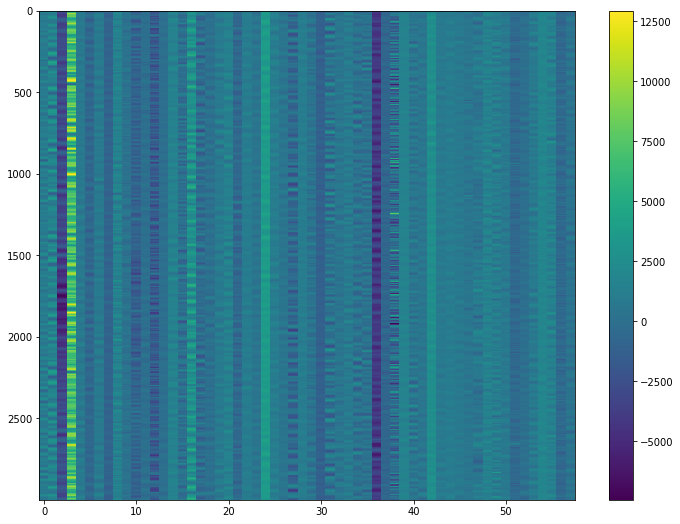

In [67]:
blok1=np.load(blok_dir+blok_filelist[0])
plt.figure(figsize=(12,9))
plt.imshow(blok1[:,0,:],aspect='auto',interpolation='none')
plt.colorbar();

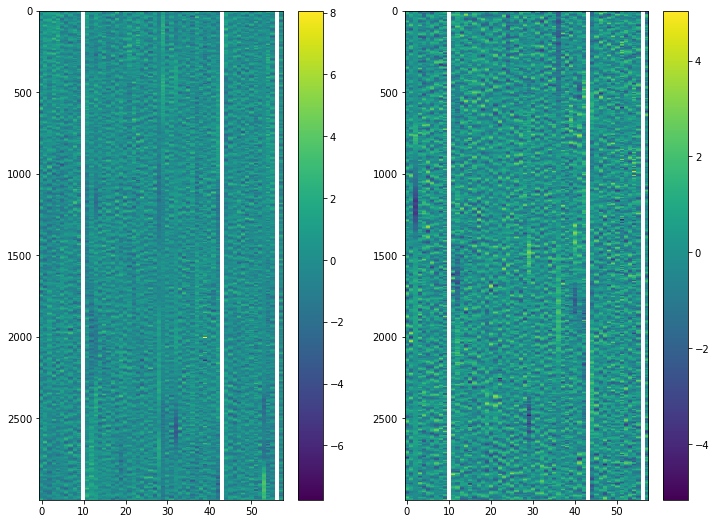

In [84]:
bloknorm1=np.load(bloknorm_dir+bloknorm_filelist[1])
fig=plt.figure(figsize=(12,9))
fig.add_subplot(1,2,1)
plt.imshow(bloknorm1[:,2,:],aspect='auto',interpolation='none')
plt.colorbar();

bloknorm1=np.load(bloknorm_dir+bloknorm_filelist[2])
fig.add_subplot(1,2,2)
plt.imshow(bloknorm1[:,2,:],aspect='auto',interpolation='none')
plt.colorbar();

In [96]:
for file in blok_filelist[0:10]:
    blok1=np.load(blok_dir+file)
    if np.sum(np.isnan(blok1))>0:
        print(file)
    print(file)

1488477499.51.npy
1353358174.15.npy
1353515761.0.npy
1353664465.13.npy
1353679290.02.npy
1353705179.31.npy
1353829042.34.npy
1354054778.18.npy
1359440285.51.npy
1359594571.88.npy


In [98]:
ii=0
for file in bloknorm_filelist:
    blok1=np.load(bloknorm_dir+file)
    if np.sum(np.isnan(blok1))>0:
        print(file)
        ii+=1
        
print(ii)

1353358174.15.npy
1353515761.0.npy
1353664465.13.npy
1353679290.02.npy
1353705179.31.npy
1353829042.34.npy
1354054778.18.npy
1359440285.51.npy
1359594571.88.npy
1359635273.21.npy
1360806512.57.npy
1360835135.79.npy
1360952448.47.npy
1361651062.72.npy
1361659400.76.npy
1361786102.14.npy
1361839927.86.npy
1361888578.42.npy
1362003829.84.npy
1362065975.88.npy
1362101944.62.npy
1362245638.93.npy
1362246790.61.npy
1362288682.54.npy
1362306594.06.npy
1362353234.06.npy
1362398448.32.npy
1363069758.22.npy
1363077770.02.npy
1363139661.52.npy
1363589819.51.npy
1364313322.17.npy
1364339725.07.npy
1364345811.59.npy
1364904181.63.npy
1365716435.74.npy
1366003168.88.npy
1366034489.08.npy
1366171012.04.npy
1366178884.61.npy
1366332277.9.npy
1366507417.38.npy
1361786641.92.npy
43


In [70]:
bloknorm_filelist[0:5]

['1478287242.54.npy',
 '1353358174.15.npy',
 '1353515761.0.npy',
 '1353664465.13.npy',
 '1353679290.02.npy']

In [93]:

np.sum(np.isnan(blok1))

0